In [1]:
import tensorflow as tf
from tensorflow import keras
from tqdm.autonotebook import tqdm
import numpy as np
from tensorflow.keras.layers import *
import matplotlib.pyplot as plt

C:\Users\joaom\.conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  This is separate from the ipykernel package so we can avoid doing imports until


In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

In [3]:
x_train = np.float32((x_train / 255))
x_test = np.float32((x_test / 255))

In [4]:
x_data = tf.data.Dataset.from_tensor_slices(x_train).shuffle(len(x_train)).batch(32)

In [82]:
dropout = 0.5
leak = 0.3

Gen = keras.Sequential([
    Flatten(),
    Dense(32),
    LeakyReLU(leak),
    Dropout(dropout),
    Dense(64),
    LeakyReLU(leak),
    Dropout(dropout),
    Dense(128),
    LeakyReLU(leak),
    Dropout(dropout),
    Dense(28*28, activation = 'sigmoid'),
    Reshape((28,28))])
Disc = keras.Sequential([
    Flatten(),
    Dense(128),
    LeakyReLU(leak),
    Dropout(dropout),
    Dense(64),
    LeakyReLU(leak),
    Dropout(dropout), 
    Dense(32),
    LeakyReLU(leak),
    Dropout(dropout),
    Dense(16),
    LeakyReLU(leak),
    Dropout(dropout),
    Dense(1, activation = 'sigmoid')
])

In [83]:
Gen_Op = keras.optimizers.Adam()
Disc_Op = keras.optimizers.Adam()

C:\Users\joaom\.conda\envs\tensorflow\lib\site-packages\matplotlib\text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


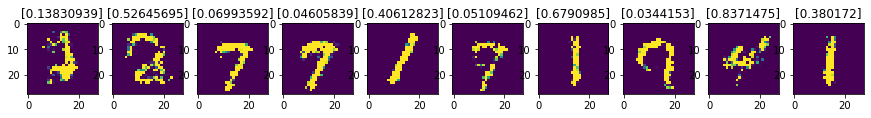

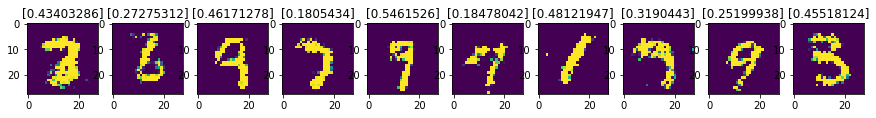

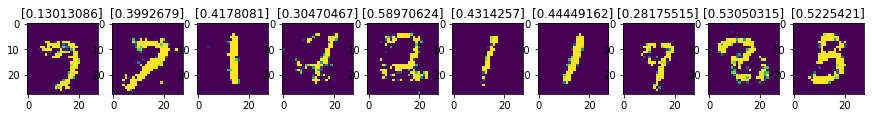

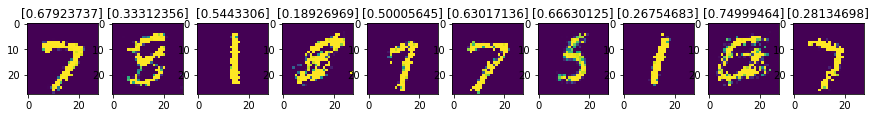

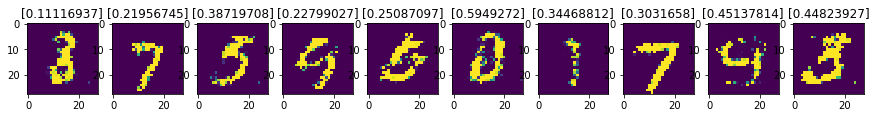

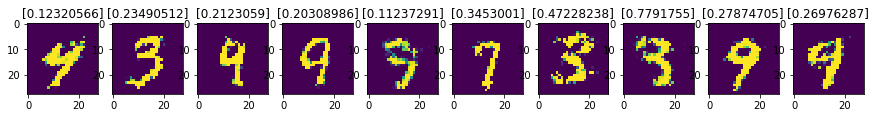

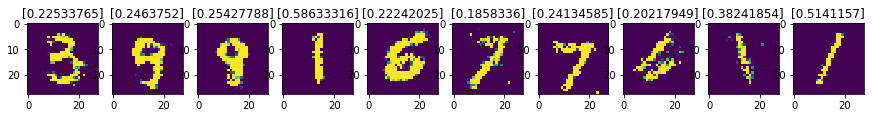

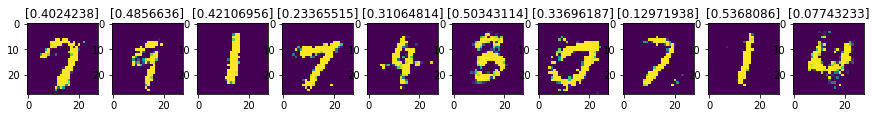

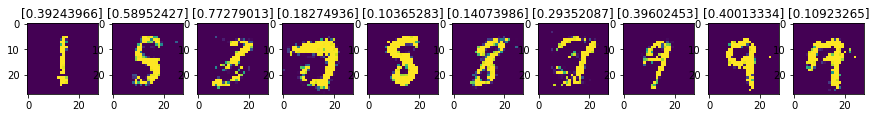

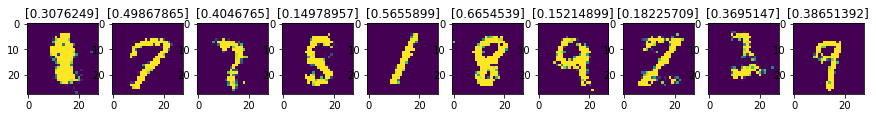

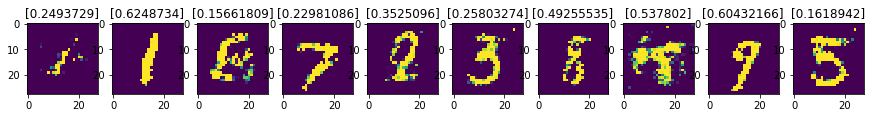

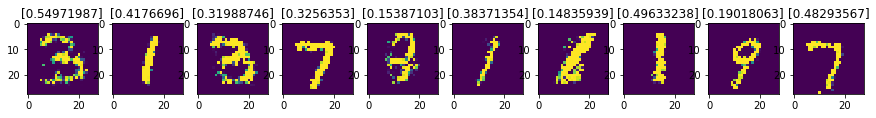

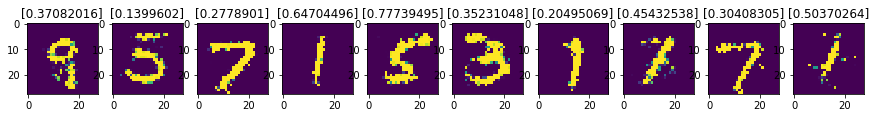

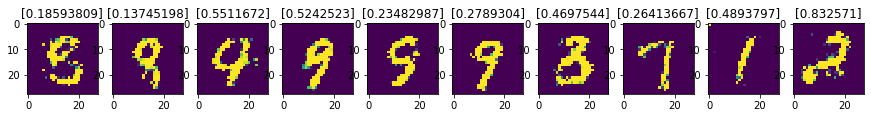

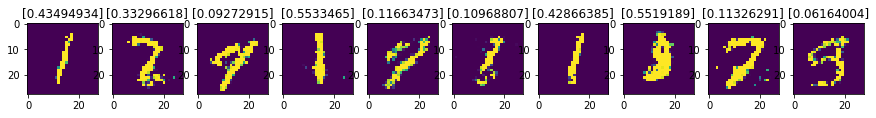

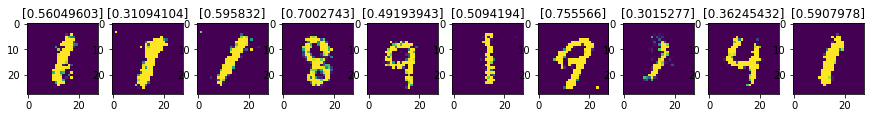

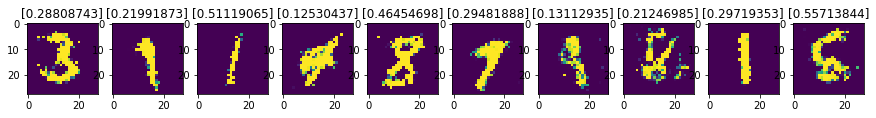

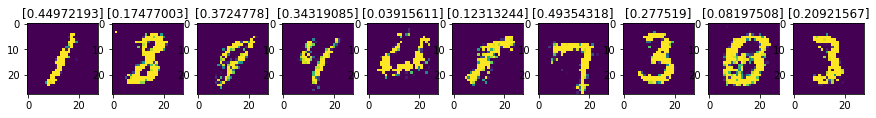

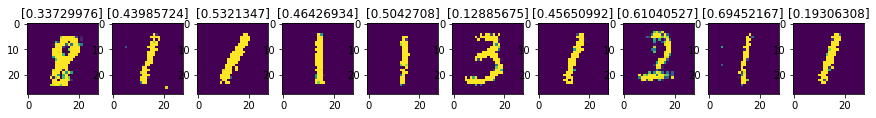

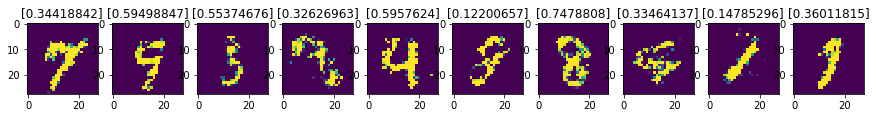

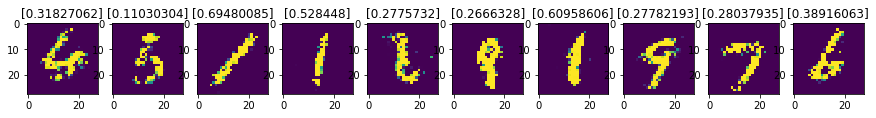

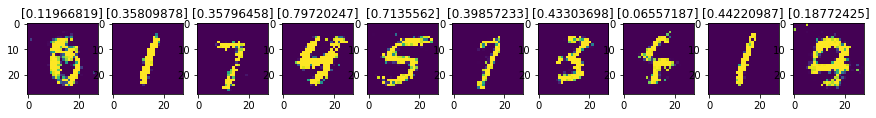

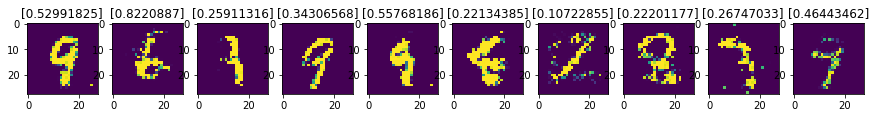

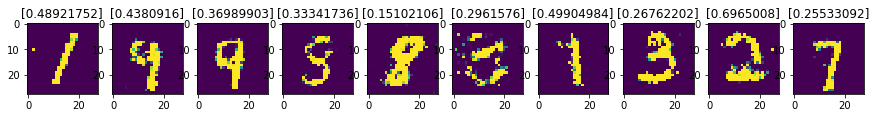

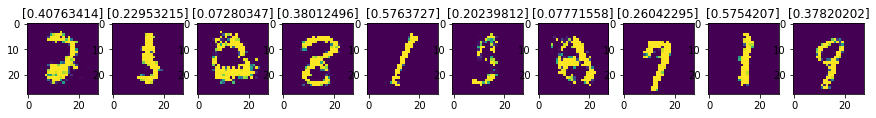

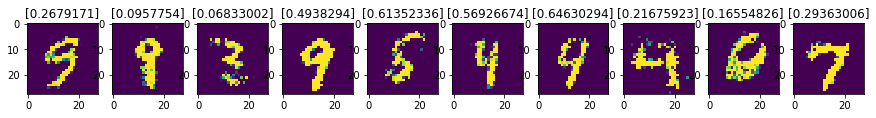

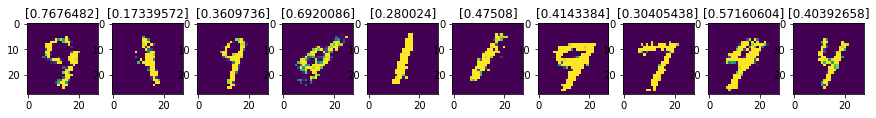

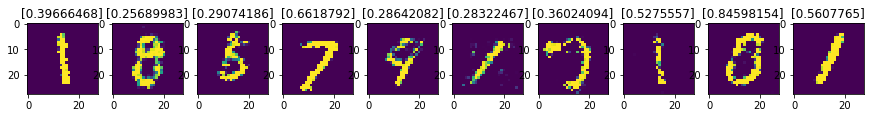

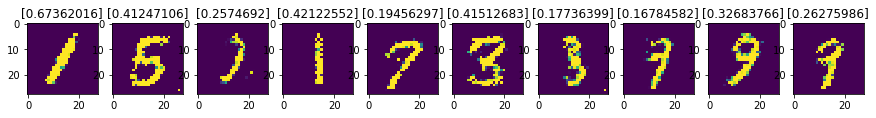

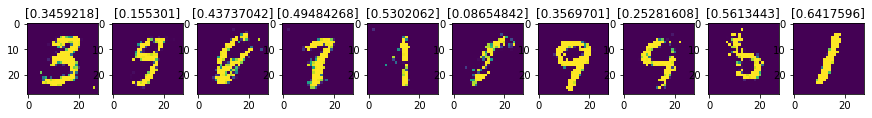

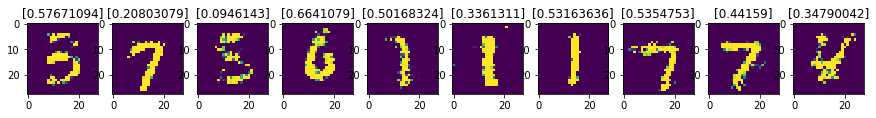

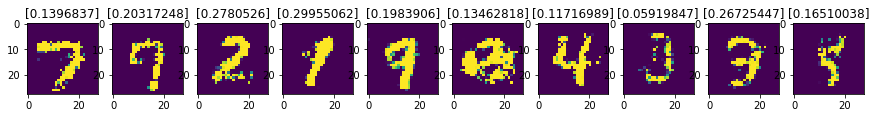

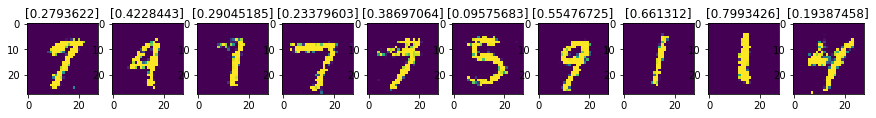

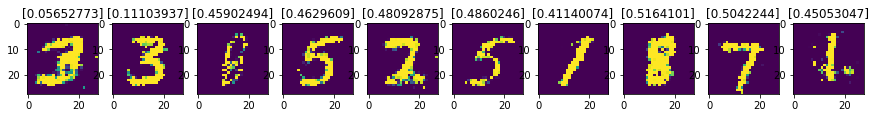

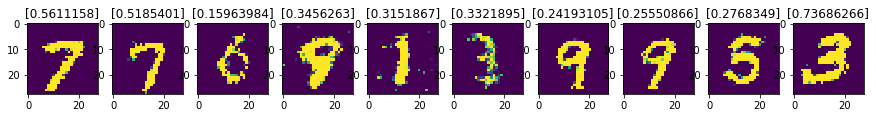

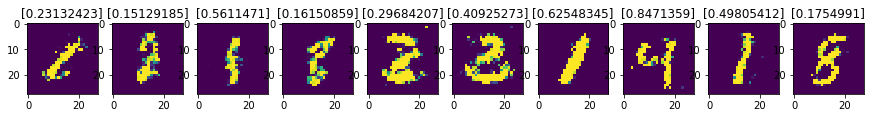

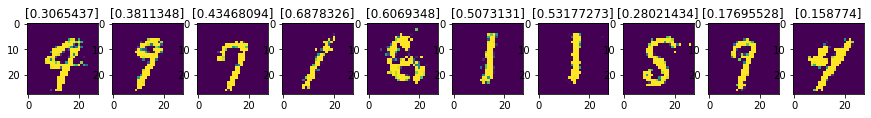

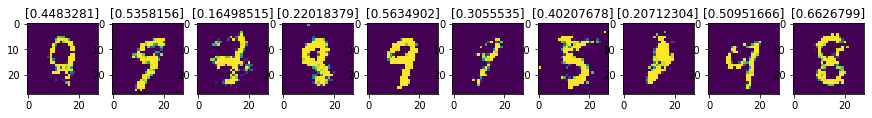

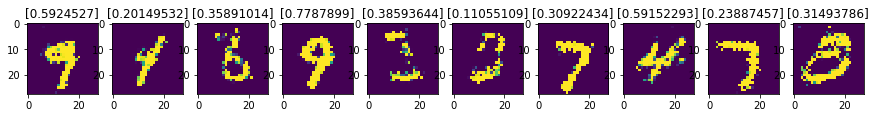

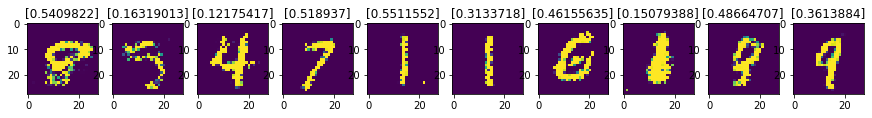

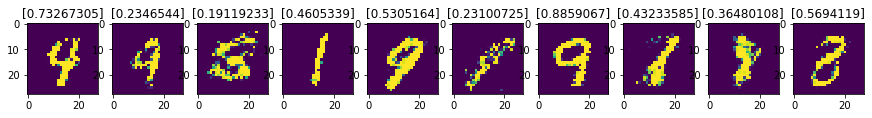

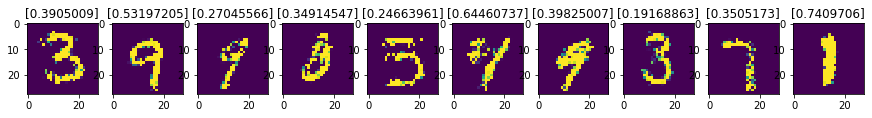

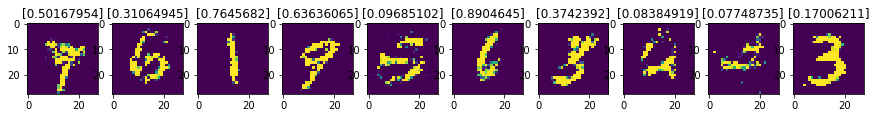

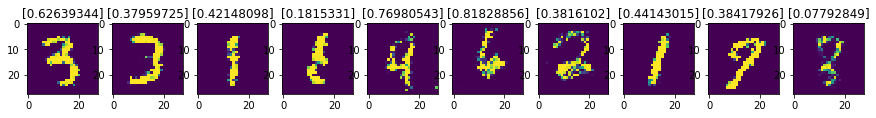

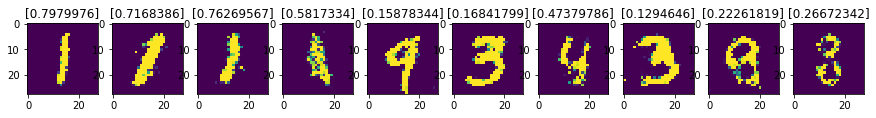

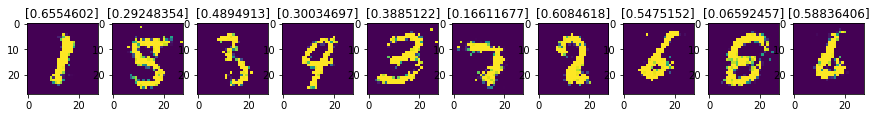

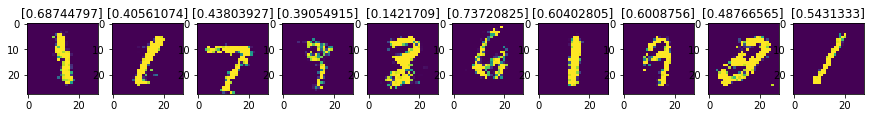

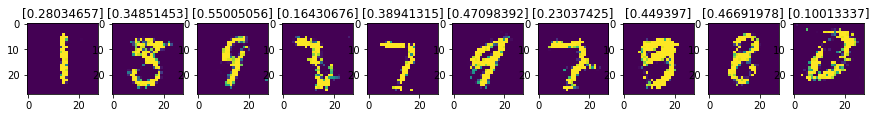

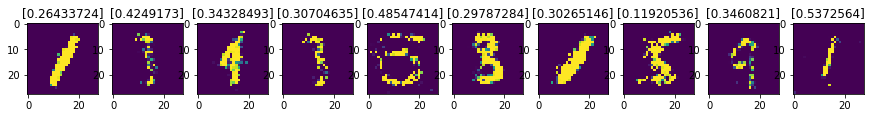

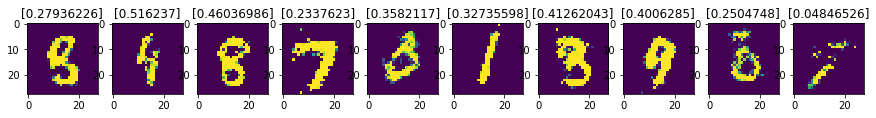

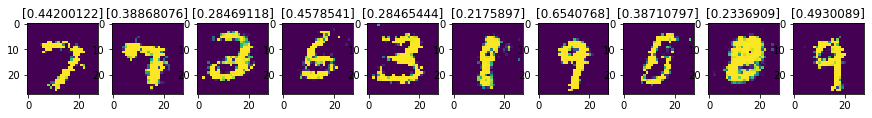

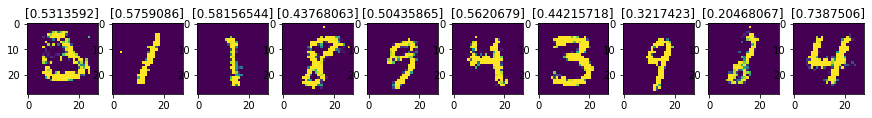

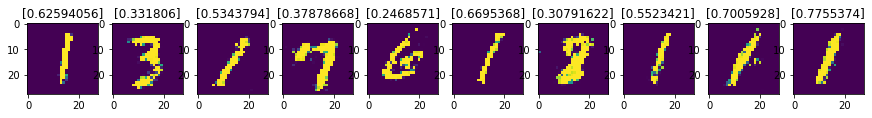

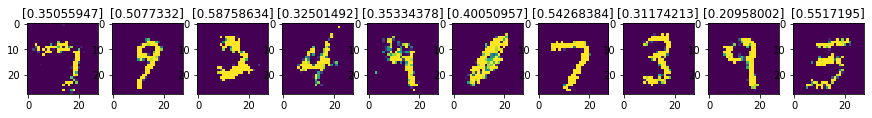

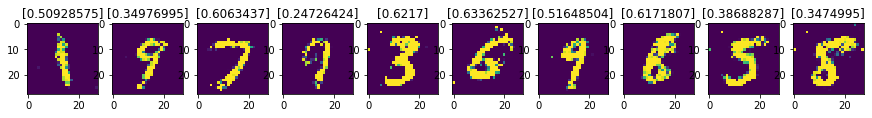

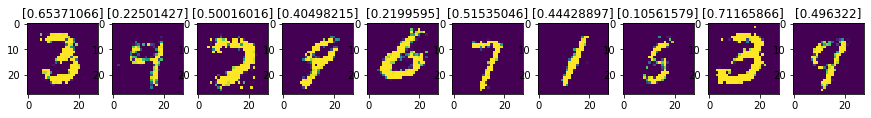

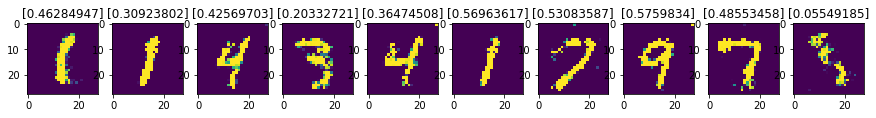

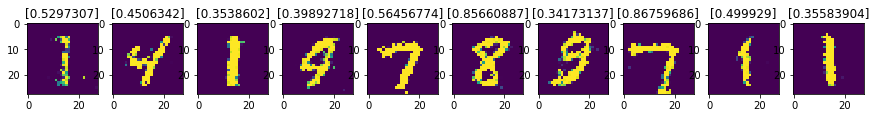

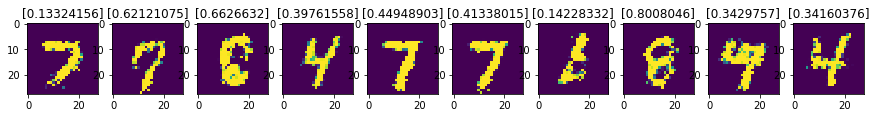

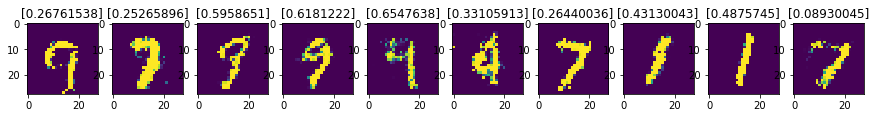

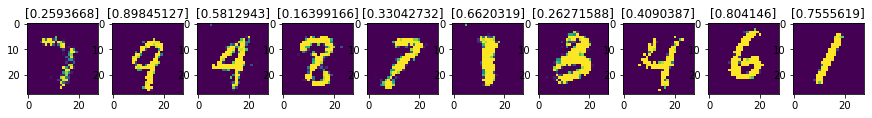

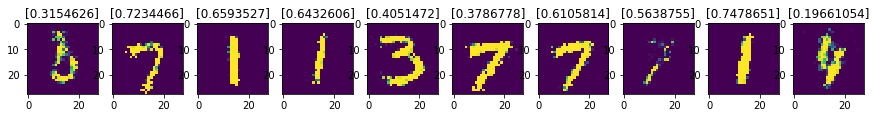

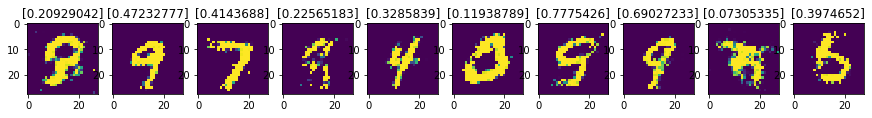

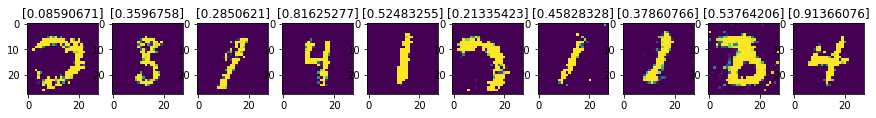

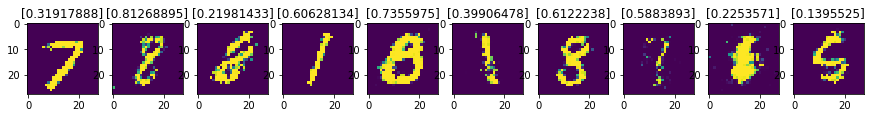

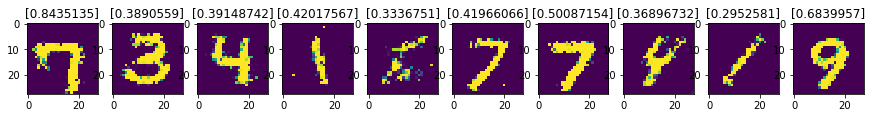

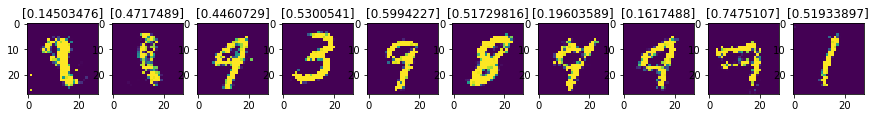

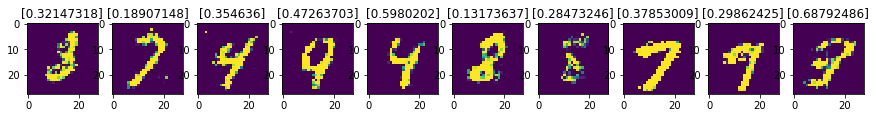

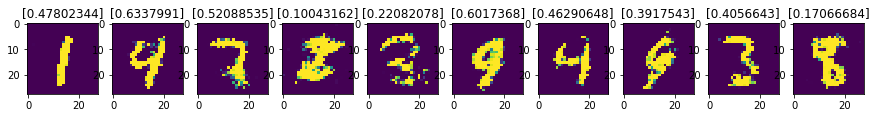

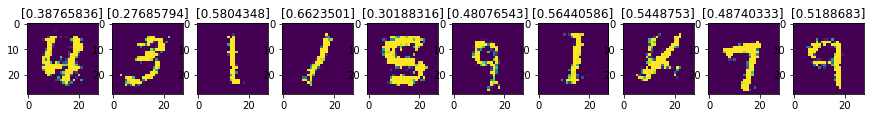

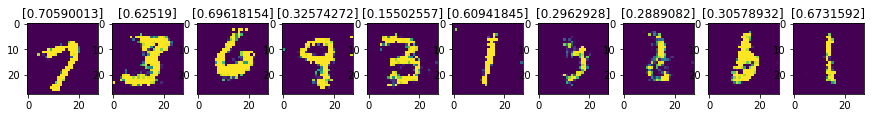

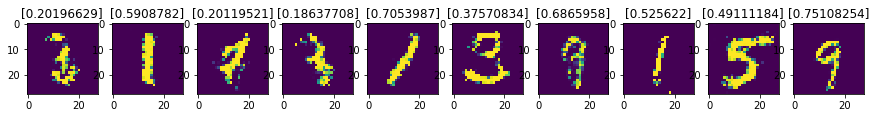

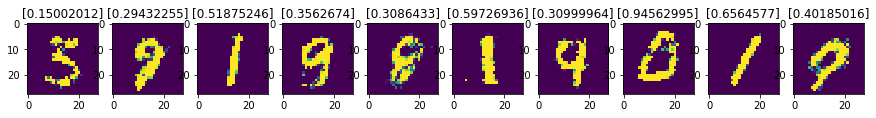

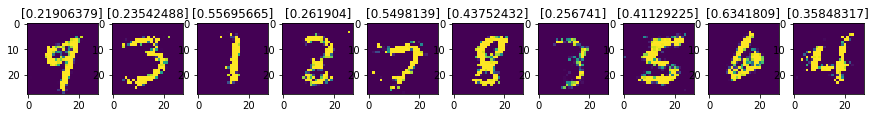

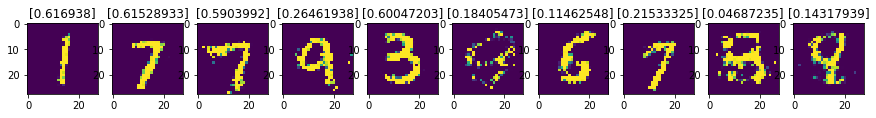

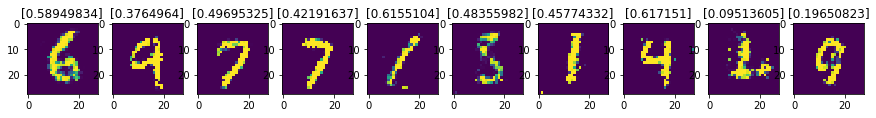

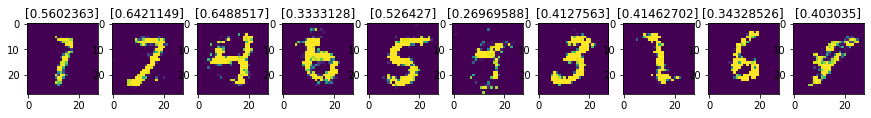

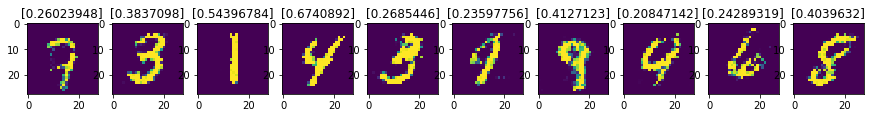

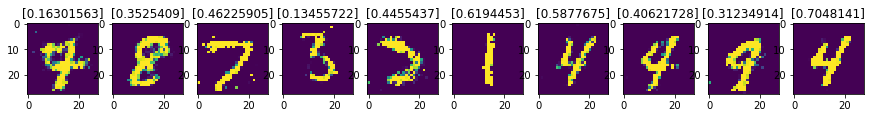

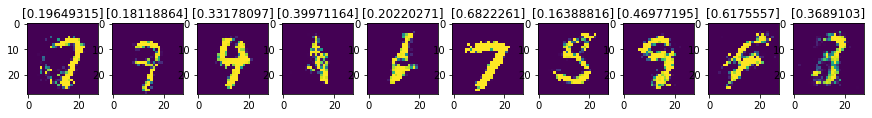

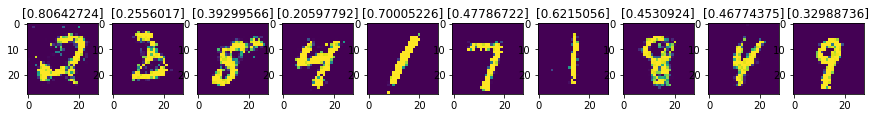

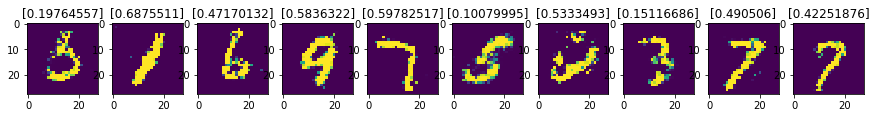

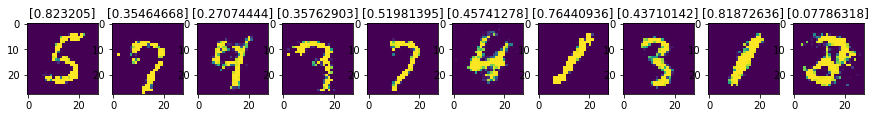

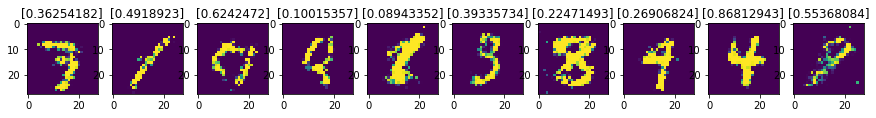

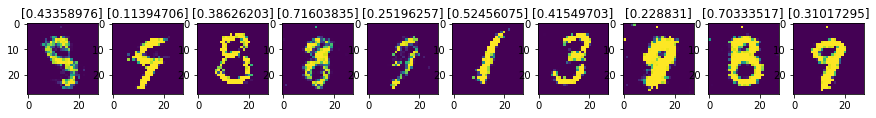

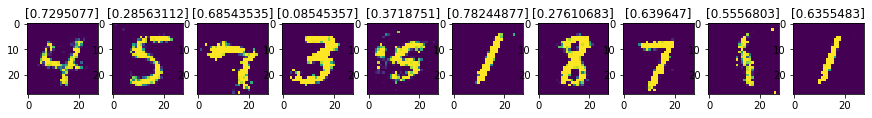

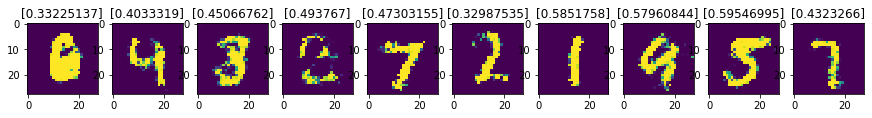

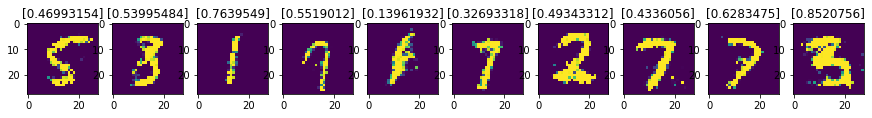

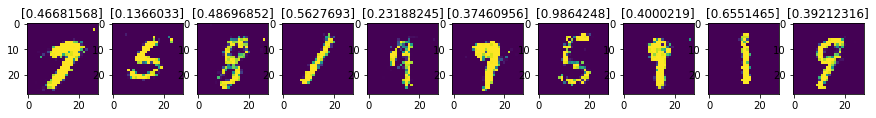

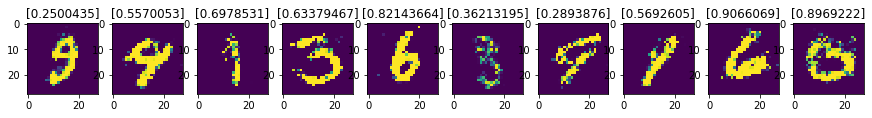

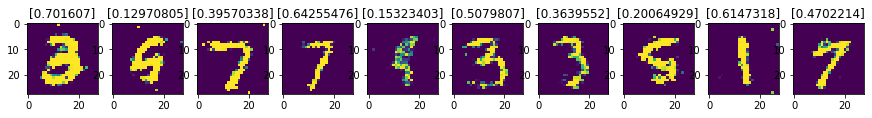

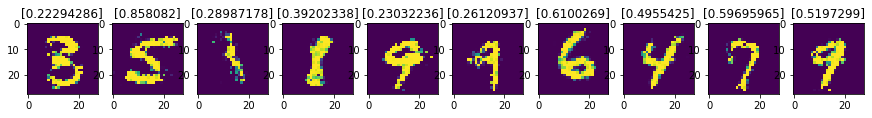

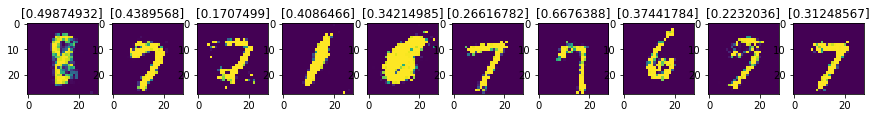

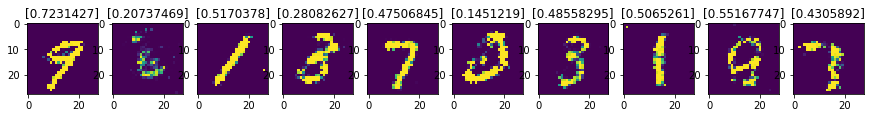

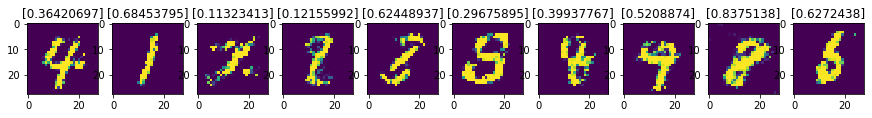

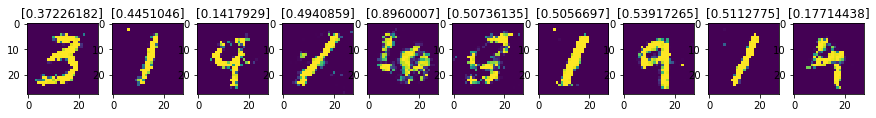

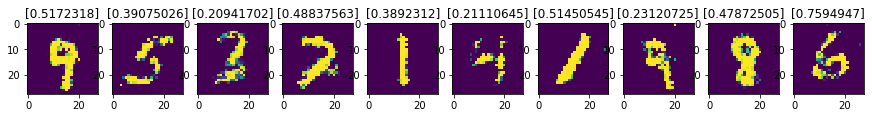

KeyboardInterrupt: 

In [86]:
epochs = 200
disc_steps = 3
gen_steps = 1
noise_level = 0.3

steps = disc_steps + gen_steps
@tf.function
def disc_step(batch):
    with tf.GradientTape() as tape:
        noise = tf.random.normal((32,100))
        x_pred = Gen(noise)
        d_pred_gen = Disc(x_pred+tf.random.normal(tf.shape(batch),0,noise_level))
        d_pred_real = Disc(batch+tf.random.normal(tf.shape(batch),0,noise_level))
        loss = tf.reduce_mean(-tf.math.log(d_pred_real+1e-7) -tf.math.log(1-d_pred_gen+1e-7))
    gradients = tape.gradient(loss, Disc.trainable_variables)
    Disc_Op.apply_gradients(zip(gradients, Disc.trainable_variables))
    return loss
@tf.function
def gen_step():
    with tf.GradientTape() as tape:
        noise = tf.random.normal((32,100))
        x_pred = Gen(noise)
        #d_pred_gen = D1(x_pred)
        #d_pred_real = D1(batch)
        #loss = tf.reduce_mean(tf.square(d_pred_gen - d_pred_real))
        loss = tf.reduce_mean(-tf.math.log(Disc(x_pred+tf.random.normal(tf.shape(x_pred),0,noise_level))+1e-7))
    gradients = tape.gradient(loss, Gen.trainable_variables)
    Gen_Op.apply_gradients(zip(gradients, Gen.trainable_variables))
    return loss


for epoch in range(epochs):
    disc_losses = []
    gen_losses = []
    
    bar = tqdm(enumerate(x_data), desc = 'Epoch ' + str(epoch+1), total = int(tf.data.experimental.cardinality(x_data))-2)
    for step, batch in bar:
        is_gen_step = (step+1)%disc_steps == 0
        
        
        loss = disc_step(batch)
        disc_losses.append(loss.numpy())
        if is_gen_step:
            for i in range(gen_steps):
                loss = gen_step()
                gen_losses.append(loss.numpy())

        mean_disc_loss = np.mean(disc_losses) if len(disc_losses) > 0 else 0
        mean_gen_loss = np.mean(gen_losses) if len(gen_losses) > 0 else 0
        bar.set_postfix(disc_loss = mean_disc_loss, gen_loss = mean_gen_loss)
    n_im = 10
    im = Gen(tf.random.normal((n_im,100)))
    plt.figure(figsize = (18/12*n_im,18/12*(1.1)))
    for i in range(n_im):
        plt.subplot(1,10,i+1)
        plt.title(Disc(im).numpy()[i])
        plt.imshow(im[i].numpy())
    plt.show()

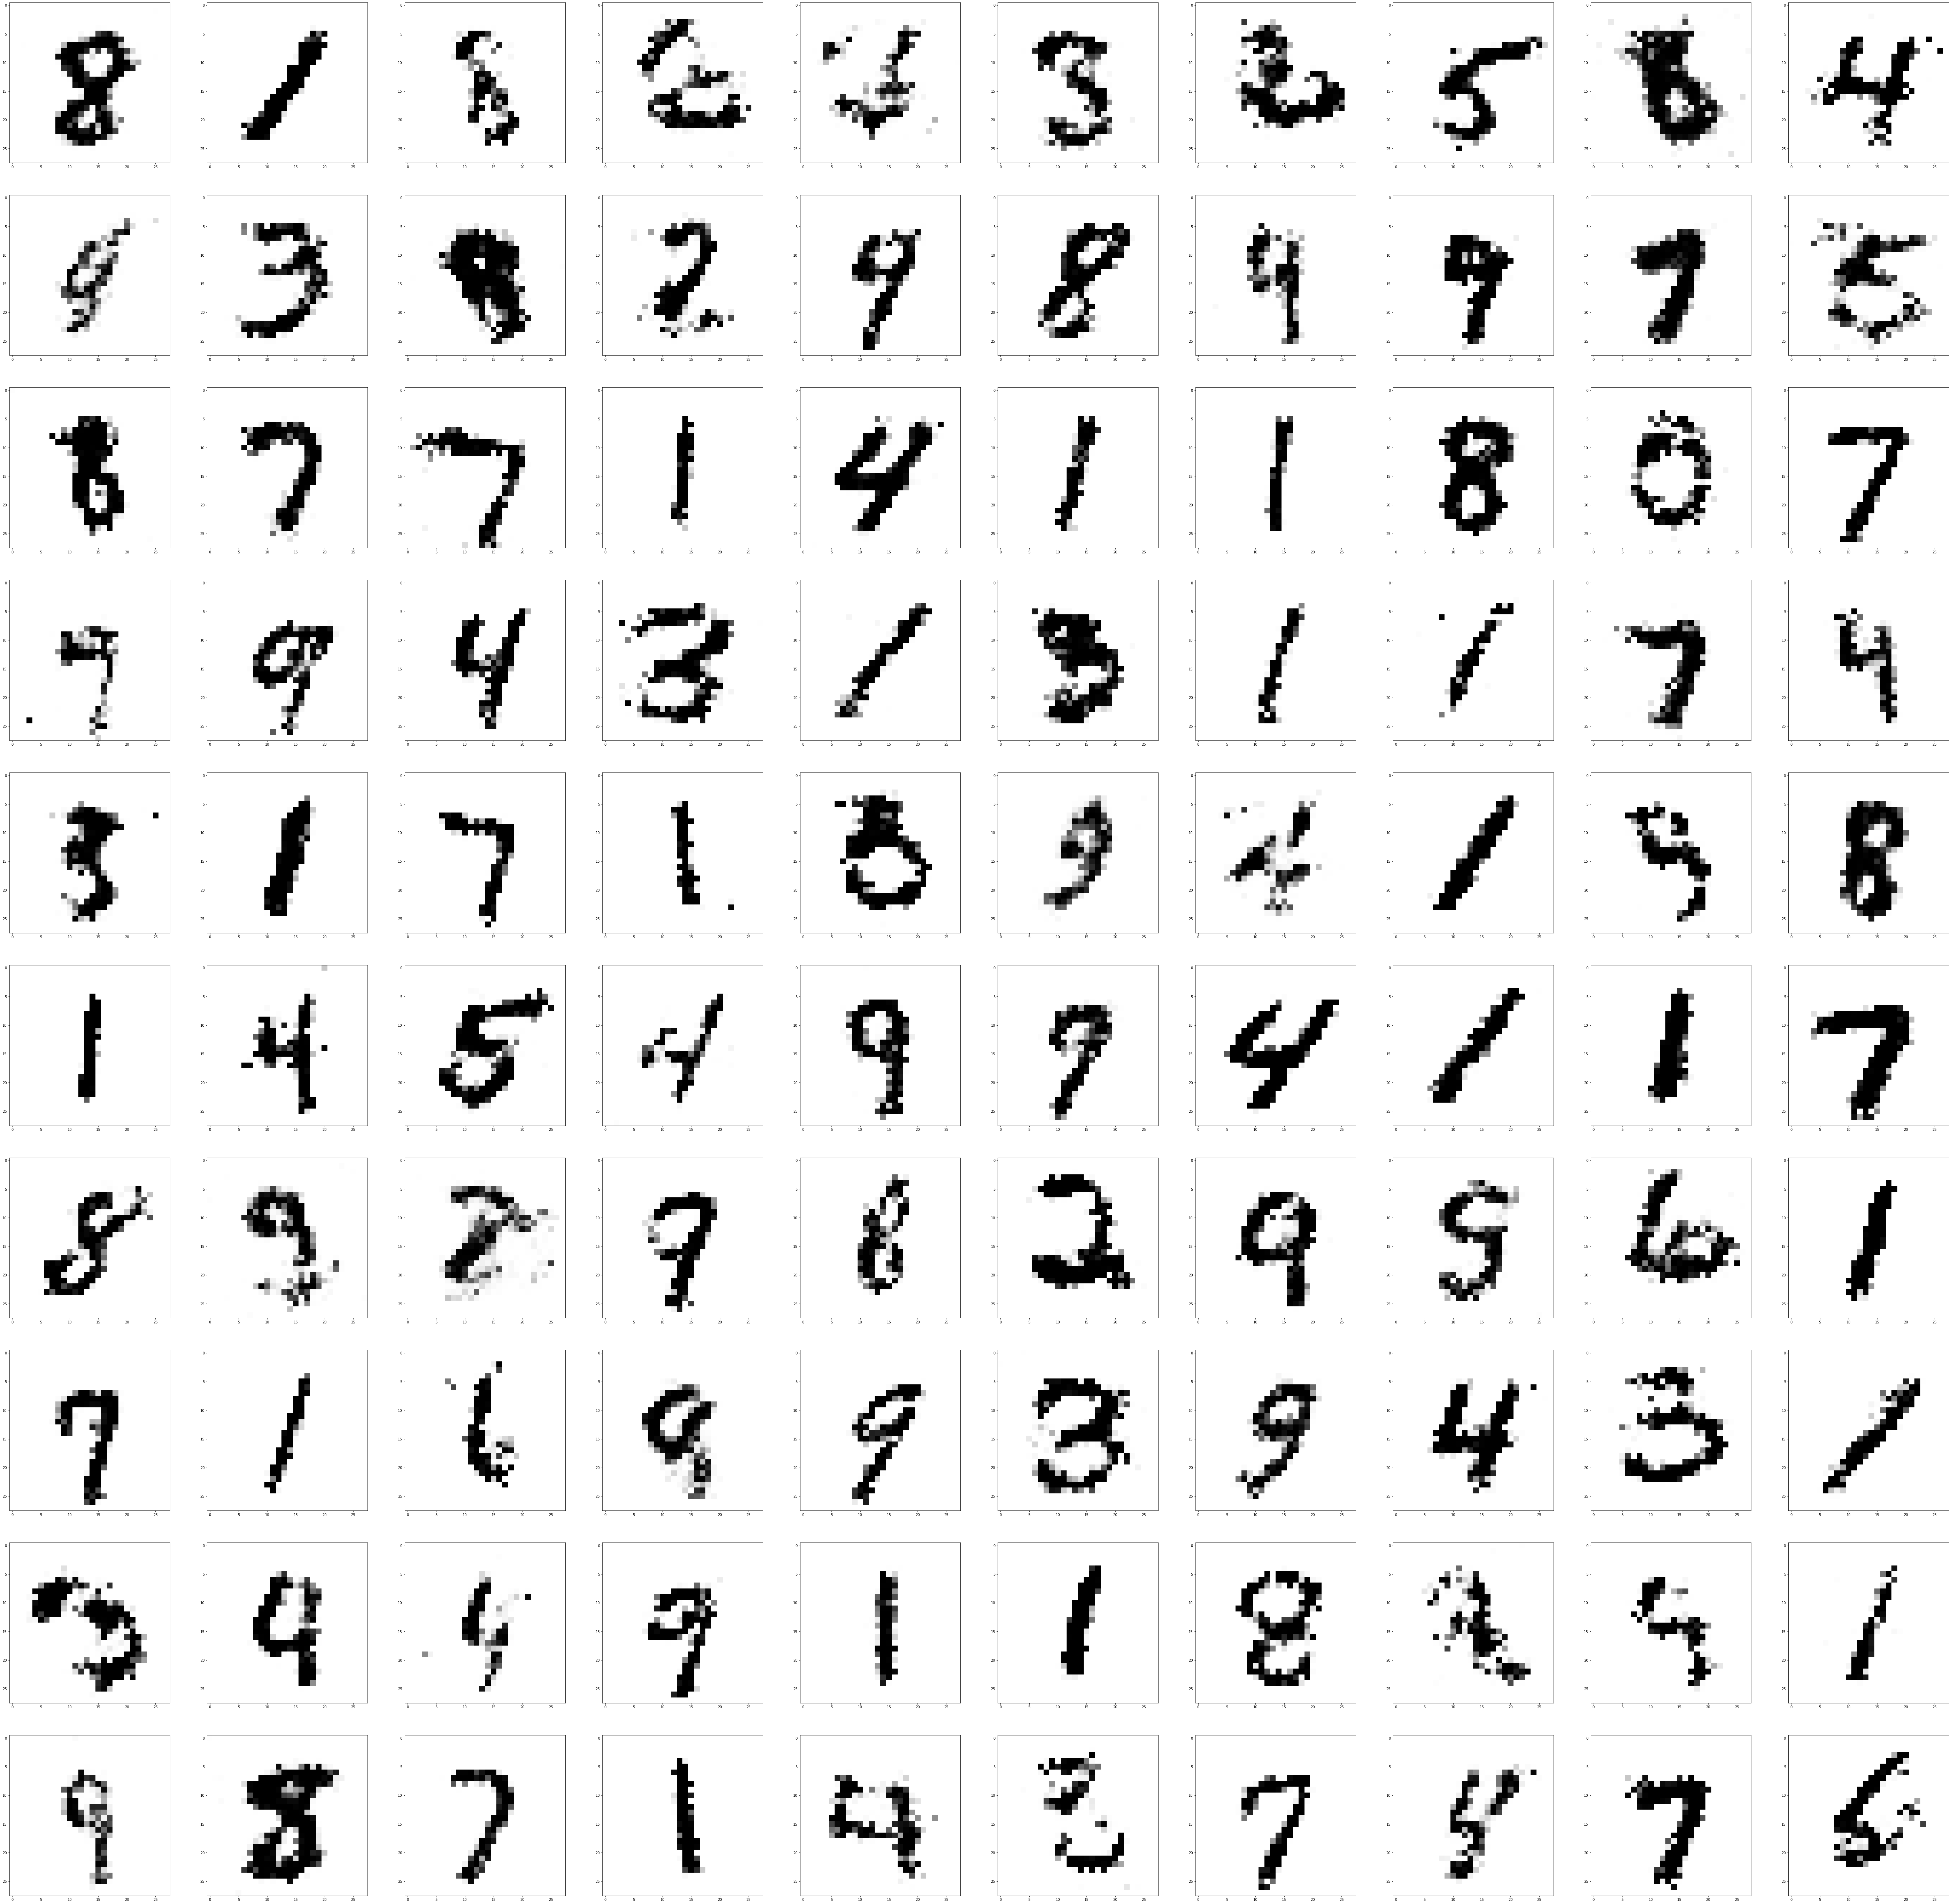

In [88]:
plt.figure(figsize = (100,100))
for i in range(10):
    for j in range(10):
        plt.subplot(10,10,10*i+j+1)
        im = Gen(tf.random.normal((2,100)))
        plt.imshow(im[0],cmap='Greys')
plt.show()

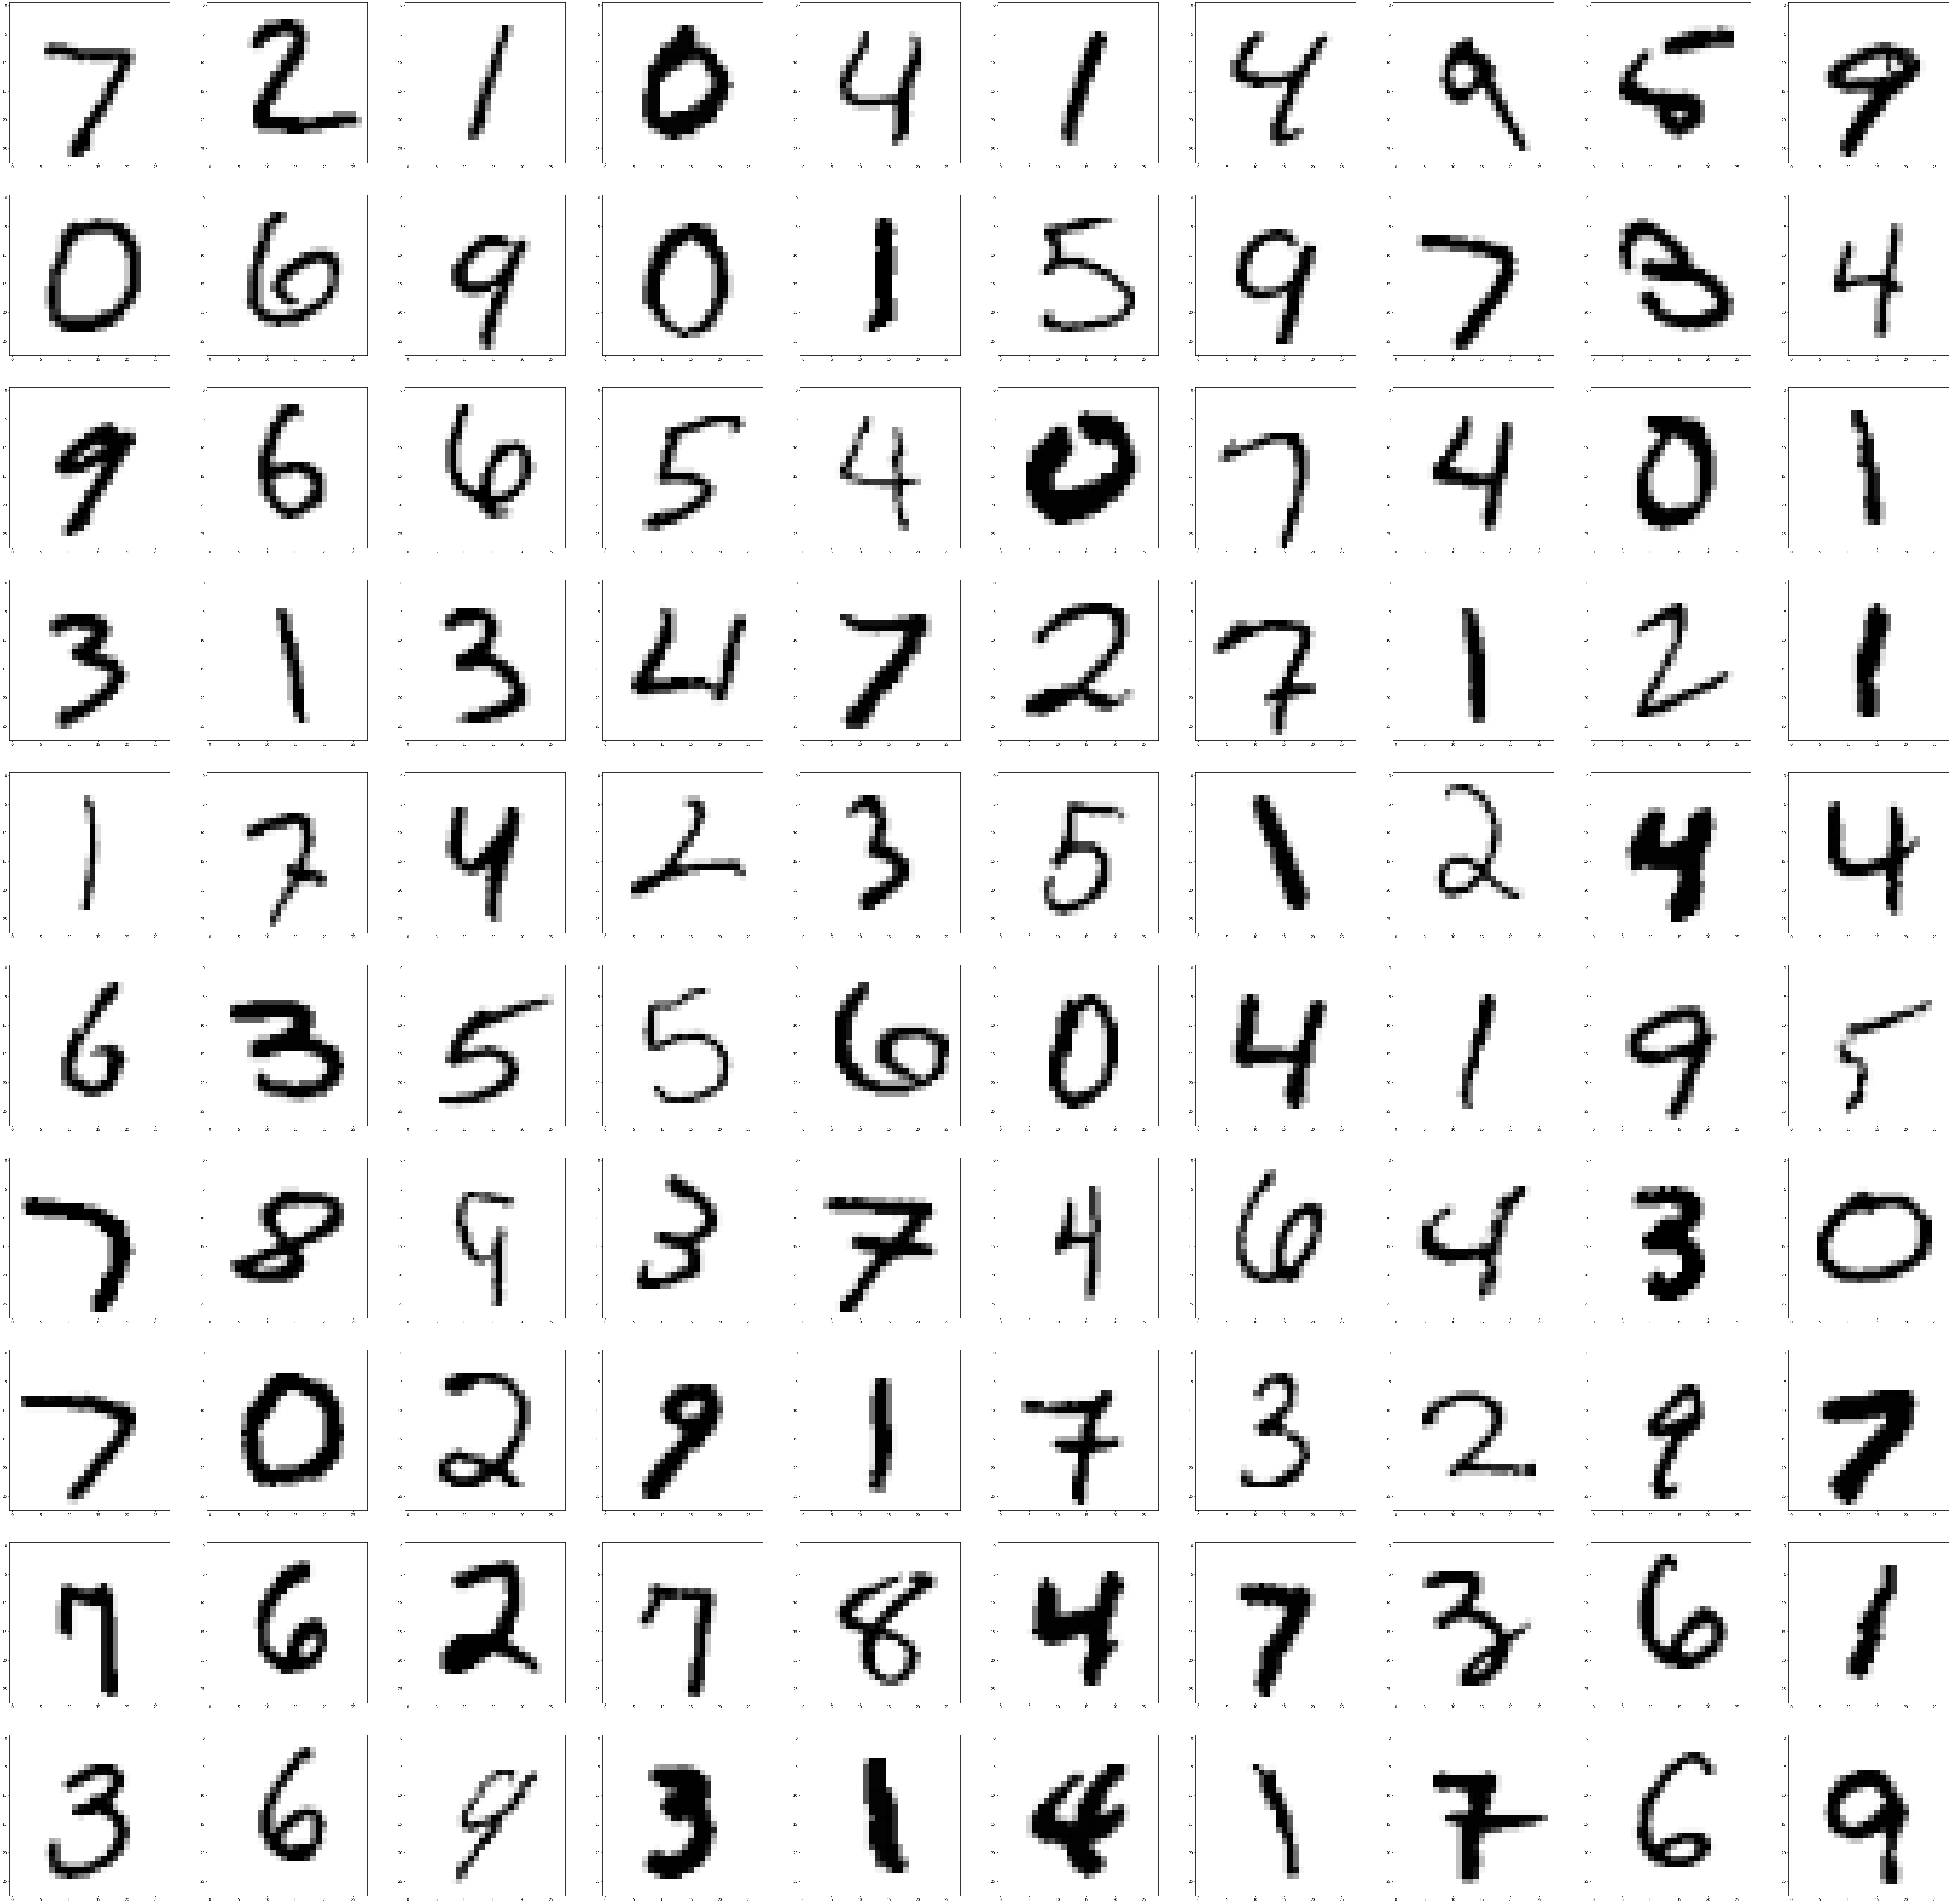

In [89]:
plt.figure(figsize = (100,100))
for i in range(10):
    for j in range(10):
        plt.subplot(10,10,10*i+j+1)
        plt.imshow(x_test[i*10+j],cmap='Greys')
plt.show()